In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns

In [3]:
reply = requests.get('https://data.europa.eu/euodp/data/storage/f/2020-08-11T140550/Finalised%20mobilities%20started%20in%202018%20-%20KA1.csv')
reply.encoding = 'utf-8'

In [4]:
csv_data = reply.text
df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False, header=0)
for i, name in enumerate(df.columns):
    print(i, name)

0 Project Reference
1 Academic Year
2 Mobility Start Month
3 Mobility End Month
4 Mobility Duration
5 Activity (mob)
6 Field of Education
7 Participant Nationality
8 Education Level
9 Participant Gender
10 Participant Profile
11 Special Needs
12 Fewer Opportunities
13 Participant Age
14 Sending Country Code
15 Sending City
16 Sending Organization
17 Receiving Country Code
18 Receiving City
19 Receiving Organization
20 Participants


In [18]:
mobility_df = df[df[df.columns[10]]=='Learner']
mobility_df = mobility_df[mobility_df['Activity (mob)'].str.contains('Student mobility for Studies')]
# consideriamo solo l'anno accademico 2018/2019 o 2017/2018?
# i numeri cambiano parecchio di anno in anno, è normale?
#mobility_df = mobility_df[mobility_df['Academic Year'].str.contains('19')]
mobility_df = mobility_df.loc[:, df.columns[np.array((16, 19, 20,))]]
print((mobility_df['Receiving Organization'].nunique()))
print((mobility_df['Sending Organization'].nunique()))

1560
2264


In [19]:
for index in range(len(mobility_df['Sending Organization'])):
    s_uni = mobility_df.iat[index,0]
    r_uni = mobility_df.iat[index,1]
    if s_uni != s_uni.upper():
        mobility_df.iat[index,0] = s_uni.upper()
    if r_uni != r_uni.upper():
        mobility_df.iat[index,1] = r_uni.upper()

print('Number of Receiving Universities: ',(mobility_df['Receiving Organization'].nunique()))
print('Number of Sending Universities: ',(mobility_df['Sending Organization'].nunique()))
mobility_df


Number of Receiving Universities:  1546
Number of Sending Universities:  2198


,Sending Organization,Receiving Organization,Participants
195,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1
196,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1
197,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1
198,MONTANUNIVERSITAT LEOBEN,THE NATIONAL MINERAL RESOURCES UNIVERSITY (THE...,1
199,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1
...,...,...,...
667190,UNIVERSITY COLLEGE LONDON,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,1
667191,UNIVERSITY COLLEGE LONDON,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,1
667192,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,UNIVERSITY COLLEGE LONDON,1
667193,UNIVERSITY COLLEGE LONDON,THE HEBREW UNIVERSITY OF JERUSALEM,1


In [20]:
nodes = np.array(list(set.union(set(mobility_df.loc[:, mobility_df.columns[0]]), set(mobility_df.loc[:, mobility_df.columns[1]]))))
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))
# Adjacency matrix
adj_matrix_crs = sparse.csr_matrix((nodes.size, nodes.size),dtype=int)
adj_matrix_csc = sparse.csc_matrix((nodes.size, nodes.size),dtype=int)

In [21]:
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

# cercasi 70 Gb di ram, no perditempo
# ns.visualize_adj(adj_matrix_crs)

In [22]:
mobility_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'Participants':'weight'},axis=1, inplace=True)
adj_matrix_crs, mobility_df, nodes_df = ns.keep_giant(ns.find_components(adj_matrix_crs, nodes_df), mobility_df)

### Degree distribution

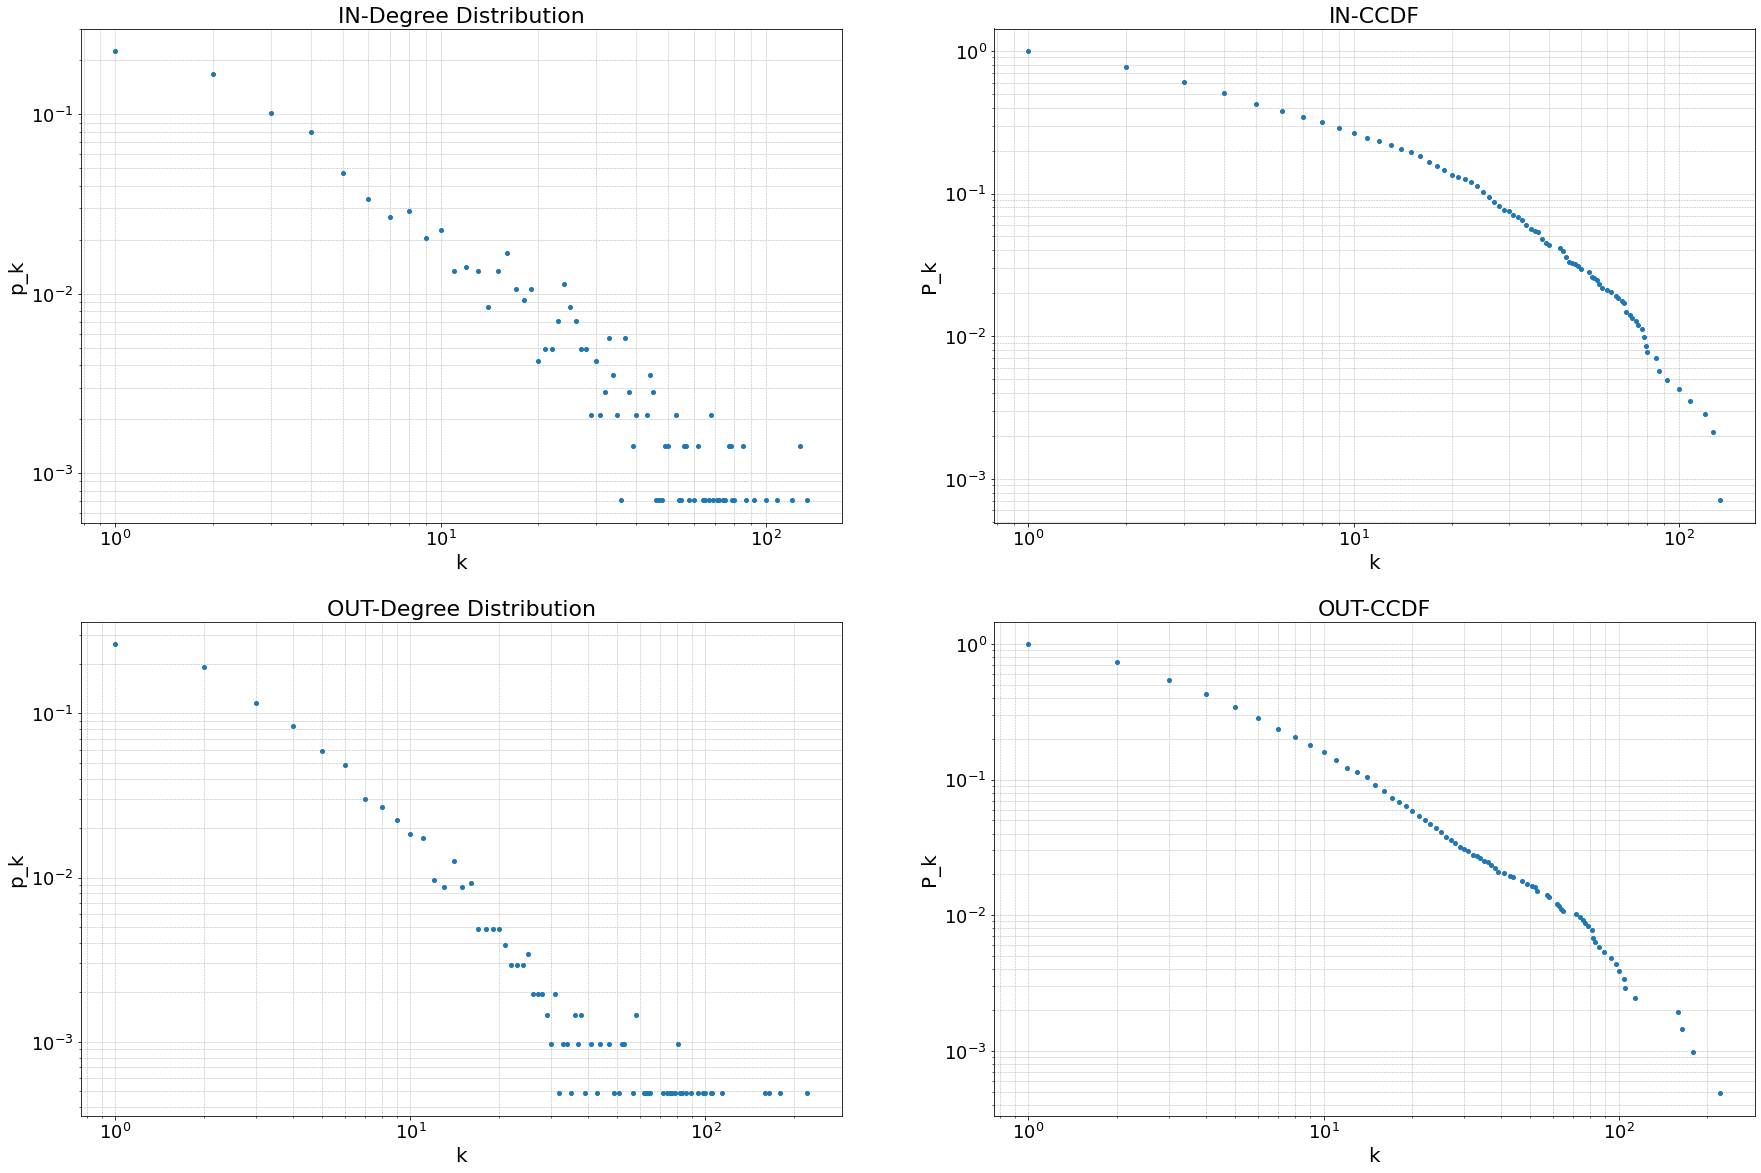

Top 10 for in degree


,Nodes,in degree
207,MASARYKOVA UNIVERZITA,134
244,UNIVERSIDAD DE GRANADA,127
654,UNIVERSIDAD DE CADIZ,127
2381,UNIVERSIDAD DE JAEN,120
2370,MIDDLE EAST TECHNICAL UNIVERSITY,108
1996,UNIVERSITA DEGLI STUDI DI PADOVA,100
261,UNIVERSITAET LEIPZIG,92
542,RIGAS TEHNISKA UNIVERSITATE,87
941,UNIVERSITE DE NICE SOPHIA ANTIPOLIS,85
6,POLITECNICO DI TORINO,85


Top 10 for out degree


,Nodes,out degree
45,UNIVERZITET U NOVOM SADU,221
333,UNIVERZITET U BEOGRADU,179
2064,IVANE JAVAKHISHVILI TBILISI STATE UNIVERSITY,164
2290,UNIVERZITET U SARAJEVU,159
1751,TARAS SHEVCHENKO NATIONAL UNIVERSITY OF KYIV,114
1114,UNIVERZITET U KRAGUJEVCU,105
416,UNIVERSITETI I PRISHTINES,104
1135,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,100
1024,UNIVERSITETI BUJQESOR I TIRANES,98
1819,ILIA STATE UNIVERSITY,94


In [23]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### HITS (NetworkX)

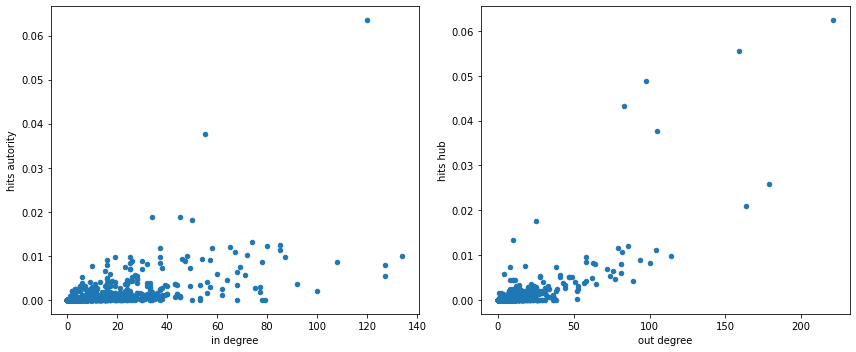

Top 10 for hits hub


,Nodes,hits hub
45,UNIVERZITET U NOVOM SADU,0.062354
2290,UNIVERZITET U SARAJEVU,0.055428
1024,UNIVERSITETI BUJQESOR I TIRANES,0.048738
1283,UNIVERZITET U NISU,0.043146
1114,UNIVERZITET U KRAGUJEVCU,0.037644
333,UNIVERZITET U BEOGRADU,0.025839
2064,IVANE JAVAKHISHVILI TBILISI STATE UNIVERSITY,0.021016
2283,JAVNA USTANOVA UNIVERZITET U ZENICI UNIVERSITA...,0.017672
743,UNIVERZITET U ISTOCNOM SARAJEVU,0.013391
177,UNIVERSITETI I TIRANES,0.012069


Top 10 for hits autority


,Nodes,hits autority
2381,UNIVERSIDAD DE JAEN,0.063463
2461,UNIVERSITA DEGLI STUDI DI MILANO,0.037720
2398,OTTO-FRIEDRICH-UNIVERSITAET BAMBERG,0.018897
1494,UNIVERSITA DEGLI STUDI DEL MOLISE,0.018757
919,UNIVERSITAET GRAZ,0.018116
135,UNIVERSITA DEGLI STUDI DELLA TUSCIA,0.013223
6,POLITECNICO DI TORINO,0.012470
36,PARIS-LODRON-UNIVERSITAT SALZBURG,0.012224
240,PHILIPPS UNIVERSITAET MARBURG,0.011911
37,UNIVERSIDADE DE AVEIRO,0.011763


In [24]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

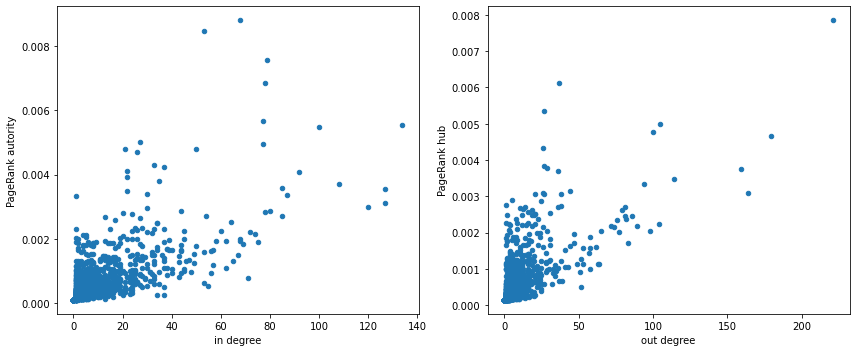

Top 10 for PageRank hub


,Nodes,PageRank hub
45,UNIVERZITET U NOVOM SADU,0.007851
90,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006115
244,UNIVERSIDAD DE GRANADA,0.005353
1114,UNIVERZITET U KRAGUJEVCU,0.004993
1135,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,0.004769
333,UNIVERZITET U BEOGRADU,0.004661
2288,SOFIISKI UNIVERSITET SVETI KLIMENT OHRIDSKI,0.004321
2228,TBILISI STATE MEDICAL UNIVERSITY,0.003846
1845,THE MANCHESTER METROPOLITAN UNIVERSITY,0.003784
2290,UNIVERZITET U SARAJEVU,0.003757


Top 10 for PageRank autority


,Nodes,PageRank autority
633,SAINT PETERSBURG STATE UNIVERSITY,0.008797
2182,THE HEBREW UNIVERSITY OF JERUSALEM,0.008478
45,UNIVERZITET U NOVOM SADU,0.007563
1135,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,0.006863
1503,THE UNIVERSITY OF EDINBURGH,0.005654
207,MASARYKOVA UNIVERZITA,0.005548
1996,UNIVERSITA DEGLI STUDI DI PADOVA,0.005465
243,UNIVERSIDAD DE HUELVA,0.005018
1558,FREIE UNIVERSITAET BERLIN,0.004955
2064,IVANE JAVAKHISHVILI TBILISI STATE UNIVERSITY,0.004785


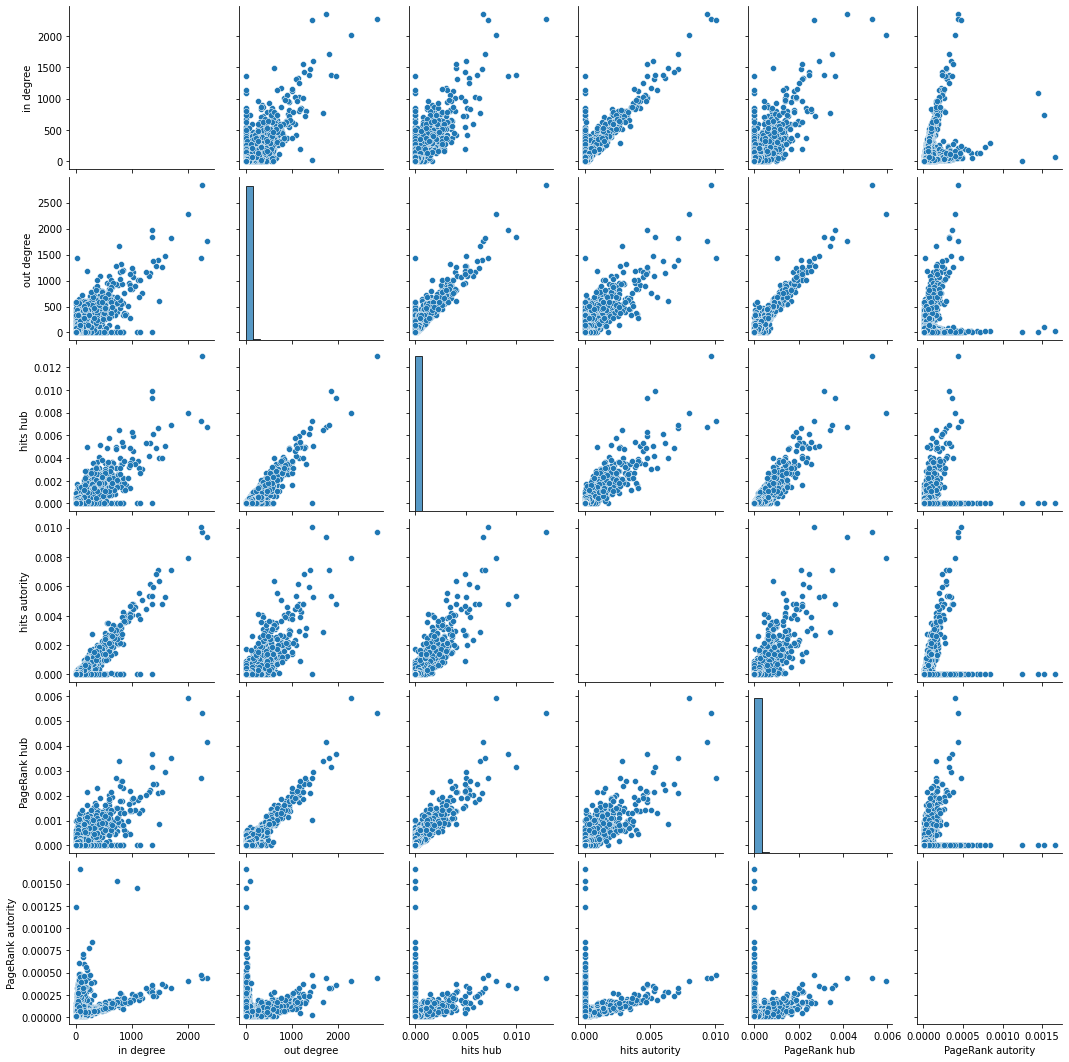

In [ ]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')
# ci vuole troppo a farlo
# sns.pairplot(scores)
# plt.show()
from IPython.display import Image
Image('pairplot_score.png',)

### Assortativity

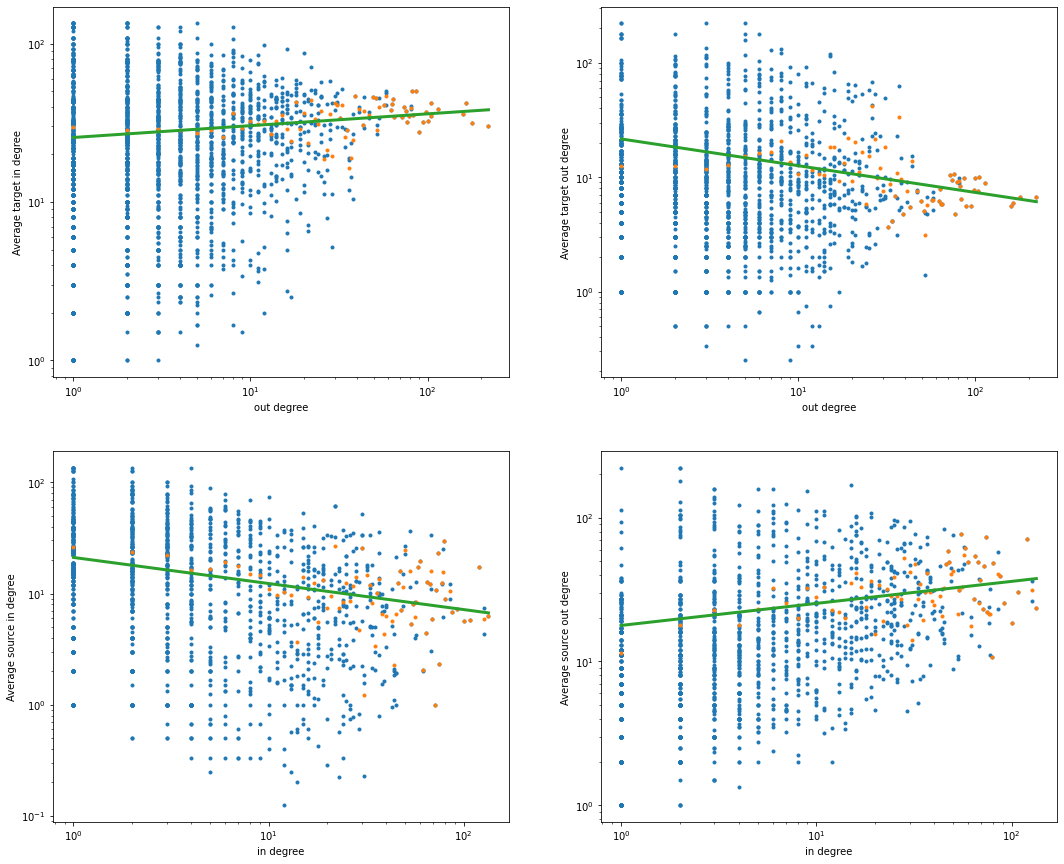

(0.07455995126835845,
 -0.23388425641884927,
 -0.2343823382831299,
 0.1531273157396571)

In [26]:
edges = mobility_df.copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)